# Notebook 2: Data Preprocessing and Augmentation

### Objectives:
1.  **Create a Preprocessing Pipeline:** Develop a robust pipeline to load, crop, normalize, and save the MRI data.
2.  **Convert 3D Volumes to 2D Slices:** Transform the raw 3D `.nii.gz` files into 2D slices suitable for training a 2D U-Net model.
3.  **Save Processed Data:** Store the clean, model-ready data in the `data/processed` directory for fast and easy access during training.

## 1. Setup and Library Imports

First, we'll import the necessary libraries and define the key directory paths for our project. This ensures our notebook is organized and can easily locate the raw data and save the processed files.

In [1]:
import os
import numpy as np
import nibabel as nib
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt

# --- Define Project Directories ---
# Use os.path.abspath and os.path.join for platform-independent paths
try:
    # Assumes the notebook is in the 'notebooks' directory
    ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), '..'))
except NameError:
    # Fallback for environments where __file__ is not defined
    ROOT_DIR = os.path.abspath(os.path.join(os.path.dirname('__file__'), '..'))

RAW_DATA_DIR = os.path.join(ROOT_DIR, 'data', 'raw', 'BraTS-Africa')
PROCESSED_DATA_DIR = os.path.join(ROOT_DIR, 'data', 'processed')

# Create the processed data directory if it doesn't exist
os.makedirs(PROCESSED_DATA_DIR, exist_ok=True)

print(f"Root Directory: {ROOT_DIR}")
print(f"Raw Data Directory: {RAW_DATA_DIR}")
print(f"Processed Data Directory: {PROCESSED_DATA_DIR}")

Root Directory: D:\Coding\GitHub\MRI-Tumor-Segmentation
Raw Data Directory: D:\Coding\GitHub\MRI-Tumor-Segmentation\data\raw\BraTS-Africa
Processed Data Directory: D:\Coding\GitHub\MRI-Tumor-Segmentation\data\processed


## 2. Locate and Map Patient Data

Before we can process the data, we need to find it. The following cell scans the `BraTS-Africa` directory, walking through both the `95_Glioma` and `51_OtherNeoplasms` subfolders to create a master list of all patient IDs. This approach ensures we use all 146 patient scans, creating the largest and most diverse dataset for training our model.

In [2]:
patient_folders = glob(os.path.join(RAW_DATA_DIR, "*", "*"))
patient_ids = [os.path.basename(path) for path in patient_folders]

print(f"Successfully located {len(patient_ids)} patient records.")
print("Sample patient IDs:", patient_ids[:5])

Successfully located 146 patient records.
Sample patient IDs: ['BraTS-SSA-00009-000', 'BraTS-SSA-00018-000', 'BraTS-SSA-00040-000', 'BraTS-SSA-00045-000', 'BraTS-SSA-00062-000']


## 3. The Preprocessing Pipeline

This is the core of the notebook. We will define a single, powerful function that encapsulates our entire preprocessing strategy for one patient. This function will perform the following steps:

1.  **Load Volumes:** Load the four MRI modalities (`t1c`, `t1n`, `t2f`, `t2w`) and the segmentation mask (`seg`).
2.  **Stack Modalities:** Combine the four MRI volumes into a single 4-channel NumPy array (`240x240x155x4`).
3.  **Crop Empty Space:** Intelligently crop the volume to remove useless "air" slices where no brain tissue is present.
4.  **Normalize Intensities:** Scale the pixel values in each channel to a standard `[0, 1]` range.
5.  **Slice and Save:** Convert the 3D volume into 2D slices and save only the slices containing tumor masks to the `data/processed` directory. This filtering step is crucial for creating a high-quality, focused training set.

In [3]:
def normalize_channel(volume):
    """Normalize a single channel to the [0, 1] range."""
    max_val = np.max(volume)
    if max_val > 0:
        return volume / max_val
    return volume

def process_patient(patient_path):
    """Loads, processes, and saves the 2D slices for a single patient."""
    patient_id = os.path.basename(patient_path)
    
    # 1. Load all 5 volumes for the patient
    try:
        t1c_path = glob(os.path.join(patient_path, f"{patient_id}-t1c.nii.gz"))[0]
        t1n_path = glob(os.path.join(patient_path, f"{patient_id}-t1n.nii.gz"))[0]
        t2f_path = glob(os.path.join(patient_path, f"{patient_id}-t2f.nii.gz"))[0]
        t2w_path = glob(os.path.join(patient_path, f"{patient_id}-t2w.nii.gz"))[0]
        seg_path = glob(os.path.join(patient_path, f"{patient_id}-seg.nii.gz"))[0]

        t1c_vol = nib.load(t1c_path).get_fdata()
        t1n_vol = nib.load(t1n_path).get_fdata()
        t2f_vol = nib.load(t2f_path).get_fdata()
        t2w_vol = nib.load(t2w_path).get_fdata()
        seg_vol = nib.load(seg_path).get_fdata()
    except IndexError:
        print(f"\n[!] Skipping patient {patient_id} due to missing files.")
        return 0

    # 2. Stack the 4 MRI modalities
    stacked_mri = np.stack([t1c_vol, t1n_vol, t2f_vol, t2w_vol], axis=-1) # Shape: (240, 240, 155, 4)

    # 3. Crop empty slices
    mask_sum = np.sum(seg_vol, axis=(0, 1))
    true_indices = np.where(mask_sum > 0)[0]
    if len(true_indices) > 0:
        min_idx, max_idx = true_indices[0], true_indices[-1]
        cropped_mri = stacked_mri[:, :, min_idx:max_idx+1, :]
        cropped_mask = seg_vol[:, :, min_idx:max_idx+1]
    else:
        # If no mask, no cropping (should not happen in this dataset)
        cropped_mri = stacked_mri
        cropped_mask = seg_vol

    # 4. Normalize each channel independently
    normalized_mri = np.zeros_like(cropped_mri, dtype=np.float32)
    for i in range(normalized_mri.shape[3]):
        normalized_mri[:, :, :, i] = normalize_channel(cropped_mri[:, :, :, i])
    
    # 5. Convert to 2D slices and save
    saved_slices = 0
    for i in range(normalized_mri.shape[2]):
        mask_slice = cropped_mask[:, :, i]
        # Save only slices that contain a tumor
        if np.sum(mask_slice) > 0:
            image_slice = normalized_mri[:, :, i, :]
            
            # Save image and mask as .npy files
            img_filename = os.path.join(PROCESSED_DATA_DIR, f"{patient_id}_slice_{min_idx+i:03d}_image.npy")
            mask_filename = os.path.join(PROCESSED_DATA_DIR, f"{patient_id}_slice_{min_idx+i:03d}_mask.npy")
            
            np.save(img_filename, image_slice)
            np.save(mask_filename, mask_slice)
            saved_slices += 1
    return saved_slices

## 4. Execute the Main Processing Loop

Now we execute the pipeline. The code below iterates through our list of all 146 patient folders, calls our `process_patient` function on each one, and uses `tqdm` to display a convenient progress bar. This will take a few minutes to run.

In [4]:
total_slices_saved = 0
for patient_path in tqdm(patient_folders, desc="Processing Patients"):
    try:
        slices = process_patient(patient_path)
        total_slices_saved += slices
    except Exception as e:
        patient_id = os.path.basename(patient_path)
        print(f"\n[!!] CRITICAL ERROR processing patient {patient_id}: {e}")

print(f"\n\nProcessing complete.")
print(f"Total 2D slices saved to {PROCESSED_DATA_DIR}: {total_slices_saved}")

Processing Patients: 100%|████████████████████████████████████████| 146/146 [08:55<00:00,  3.66s/it]


[!!] CRITICAL ERROR processing patient BraTS-SSA-00230-000: Empty file: 'D:/Coding/GitHub/MRI-Tumor-Segmentation/data/raw/BraTS-Africa/95_Glioma/BraTS-SSA-00230-000/BraTS-SSA-00230-000-t2w.nii.gz'


Processing complete.
Total 2D slices saved to D:\Coding\GitHub\MRI-Tumor-Segmentation\data\processed: 10692


## 5. Verification

The final and most important step is to verify our work. We'll load one of the saved image slices and its corresponding mask from the `data/processed` directory. We will then check their shapes, data types, and value ranges, and visualize them to ensure they look correct. This confirms our entire pipeline has worked as expected.

--- Verifying Sample 1: BraTS-SSA-00127-000_slice_082_image.npy ---
  Image shape: (240, 240, 4), dtype: float32
  Mask shape:  (240, 240), dtype: float64
  Image value range: [0.00, 0.95]
  Mask unique values: [0. 1. 2. 3.]

--- Verifying Sample 2: BraTS-SSA-00198-000_slice_099_image.npy ---
  Image shape: (240, 240, 4), dtype: float32
  Mask shape:  (240, 240), dtype: float64
  Image value range: [0.00, 0.98]
  Mask unique values: [0. 1. 2. 3.]

--- Verifying Sample 3: BraTS-SSA-00175-000_slice_093_image.npy ---
  Image shape: (240, 240, 4), dtype: float32
  Mask shape:  (240, 240), dtype: float64
  Image value range: [0.00, 0.96]
  Mask unique values: [0. 1. 2. 3.]

--- High-quality verification figure saved to: D:\Coding\GitHub\MRI-Tumor-Segmentation\figures\preprocessing_verification_samples.png ---


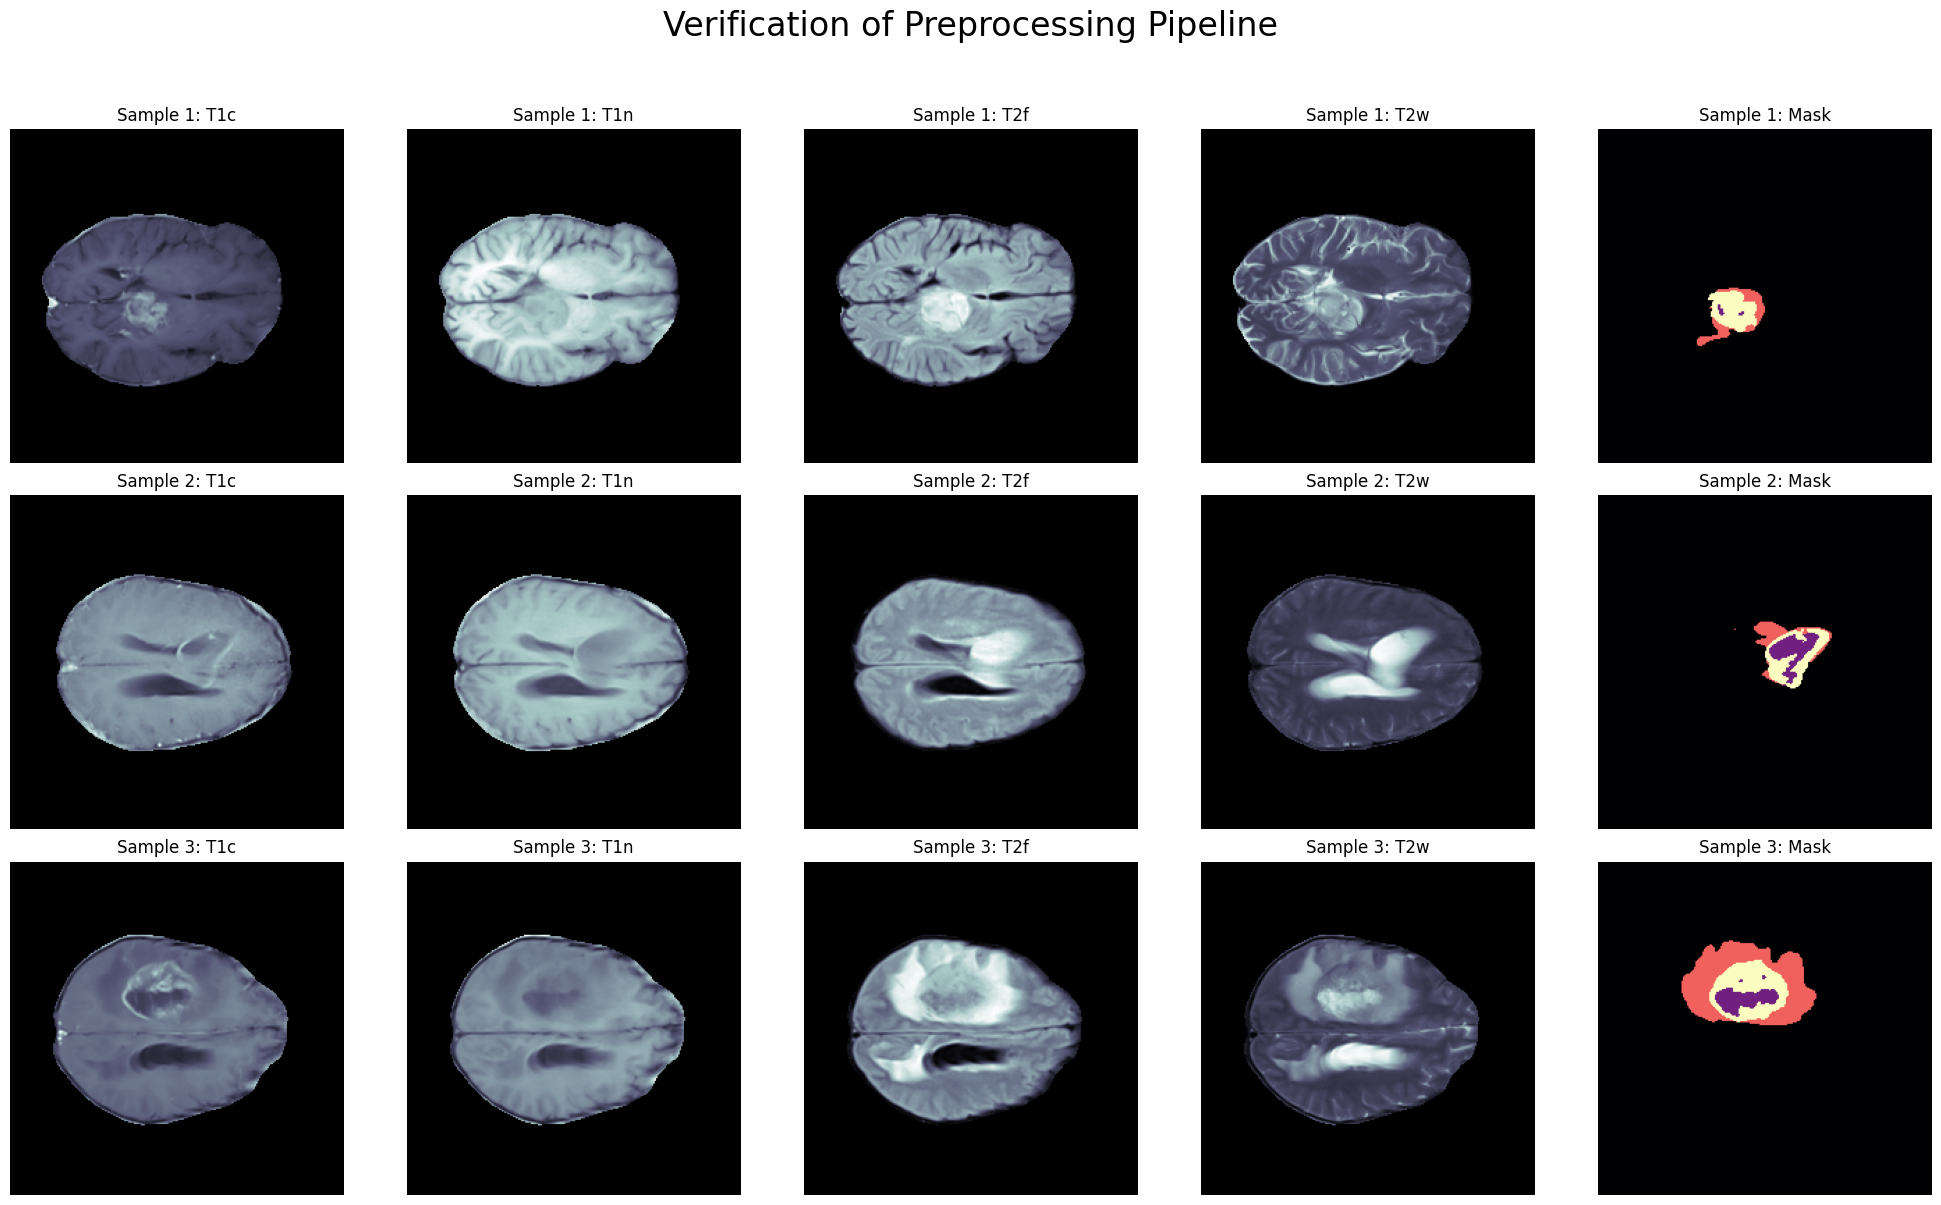

In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

# --- Define Project Directories (assuming this is defined in a previous cell) ---
try:
    ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), '..'))
except NameError:
    ROOT_DIR = os.path.abspath(os.path.join(os.path.dirname('__file__'), '..'))
PROCESSED_DATA_DIR = os.path.join(ROOT_DIR, 'data', 'processed')
FIGURES_DIR = os.path.join(ROOT_DIR, 'figures')
os.makedirs(FIGURES_DIR, exist_ok=True)
# -------------------------------------------------------------------------------


# Find all processed image files
processed_images = glob(os.path.join(PROCESSED_DATA_DIR, "*_image.npy"))

if not processed_images:
    print("No processed images found. Please run the processing loop first.")
else:
    # --- 1. Select 3 random samples ---
    num_samples = min(3, len(processed_images)) # Ensure we don't exceed available images
    sample_image_paths = np.random.choice(processed_images, size=num_samples, replace=False)

    # --- 2. Create the plot structure ---
    fig, axes = plt.subplots(num_samples, 5, figsize=(20, 4 * num_samples))
    plt.suptitle('Verification of Preprocessing Pipeline', fontsize=24, y=1.0)

    modalities = ['T1c', 'T1n', 'T2f', 'T2w']

    # --- 3. Loop through samples and plot ---
    for i, image_path in enumerate(sample_image_paths):
        mask_path = image_path.replace("_image.npy", "_mask.npy")

        # Load the image and mask
        image_slice = np.load(image_path)
        mask_slice = np.load(mask_path)

        # --- Verification Checks (printed for each sample) ---
        print(f"--- Verifying Sample {i+1}: {os.path.basename(image_path)} ---")
        print(f"  Image shape: {image_slice.shape}, dtype: {image_slice.dtype}")
        print(f"  Mask shape:  {mask_slice.shape}, dtype: {mask_slice.dtype}")
        print(f"  Image value range: [{np.min(image_slice):.2f}, {np.max(image_slice):.2f}]")
        print(f"  Mask unique values: {np.unique(mask_slice)}\n")

        # Get the correct row of axes
        # If num_samples is 1, axes is a 1D array, otherwise it's 2D
        row_axes = axes[i] if num_samples > 1 else axes

        # Plot the 4 MRI modalities
        for j in range(4):
            row_axes[j].imshow(image_slice[:, :, j], cmap='bone')
            row_axes[j].set_title(f'Sample {i+1}: {modalities[j]}')
            row_axes[j].axis('off')

        # Plot the segmentation mask
        row_axes[4].imshow(mask_slice, cmap='magma')
        row_axes[4].set_title(f'Sample {i+1}: Mask')
        row_axes[4].axis('off')

    # --- 4. Finalize and save the figure ---
    plt.tight_layout(rect=[0, 0, 1, 0.97]) # Adjust layout to make room for suptitle
    
    figure_path = os.path.join(FIGURES_DIR, 'preprocessing_verification_samples.png')
    plt.savefig(
        figure_path,
        dpi=300,           # High resolution
        bbox_inches='tight', # Remove extra whitespace
        facecolor='white'    # White background
    )
    
    print(f"--- High-quality verification figure saved to: {figure_path} ---")
    plt.show()

## End of Notebook 2

This concludes our data preprocessing phase. We have successfully created a clean, normalized, and model-ready dataset of 2D slices. Each slice contains four channels of MRI data, and we have a corresponding segmentation mask for each.

We are now fully prepared to proceed to **Notebook 3: Model Training and Benchmarking**.